
Customer Statistics:
Region
South America    59
Europe           50
North America    46
Asia             45
Name: count, dtype: int64

Product Statistics:
Category
Books          26
Electronics    26
Clothing       25
Home Decor     23
Name: count, dtype: int64


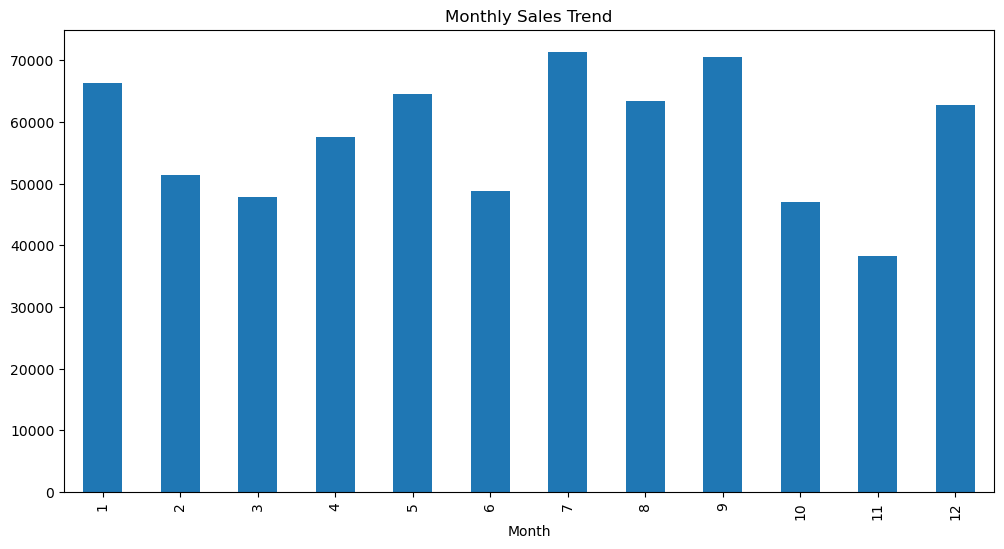

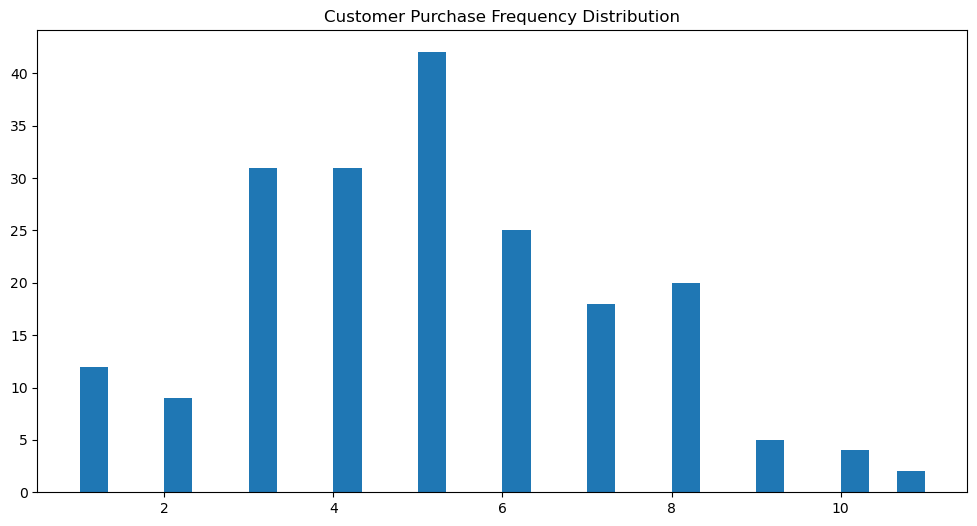

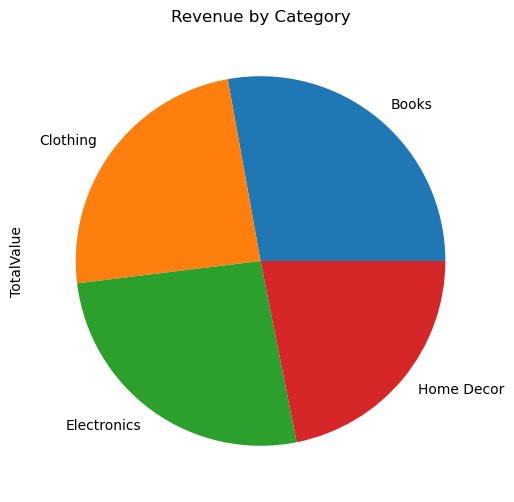

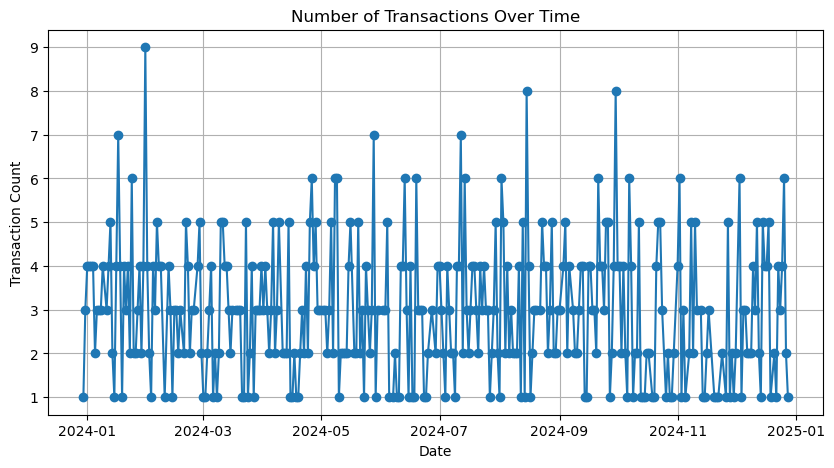

Epoch 1/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 2/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 3/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 4/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 5/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 6/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 7/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 8/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 9/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500
Epoch 10/10 - Train Accuracy: 0.9937, Test Accuracy: 0.9500

Final Test Accuracy: 0.9500
Davies-Bouldin Index: 1.4249


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


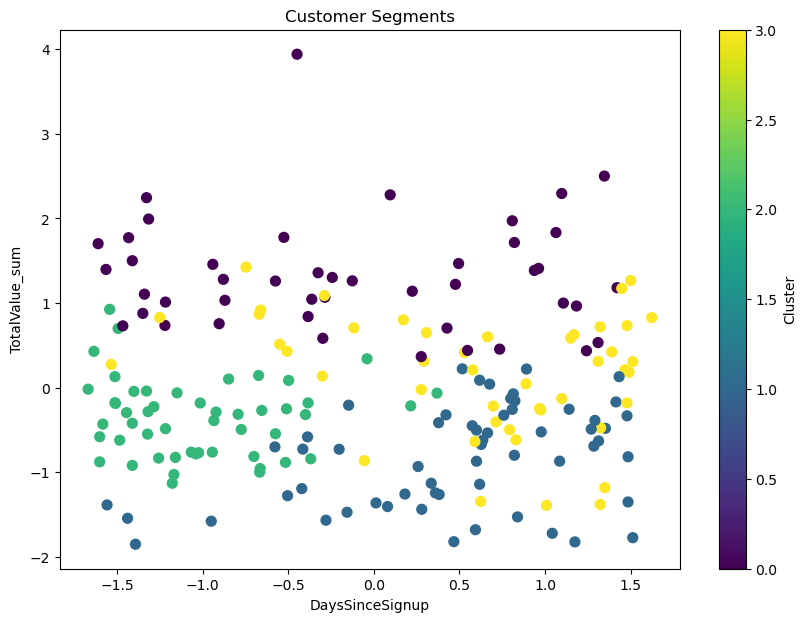

In [39]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from datetime import datetime

# Load the datasets
customers_df = pd.read_csv('Customers.csv')
products_df = pd.read_csv('Products.csv')
transactions_df = pd.read_csv('Transactions.csv')

# Task 1: Exploratory Data Analysis (EDA)
def perform_eda():
    # Basic statistics
    print("\nCustomer Statistics:")
    print(customers_df['Region'].value_counts())
    print("\nProduct Statistics:")
    print(products_df['Category'].value_counts())
    
    # Transaction analysis
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    transactions_df['Month'] = transactions_df['TransactionDate'].dt.month
    
    # Monthly sales trend
    monthly_sales = transactions_df.groupby('Month')['TotalValue'].sum()
    plt.figure(figsize=(12, 6))
    monthly_sales.plot(kind='bar')
    plt.title('Monthly Sales Trend')
    plt.show()
    plt.savefig('monthly_sales.png')
    plt.close()
    
    # Customer purchase frequency
    customer_frequency = transactions_df['CustomerID'].value_counts()
    plt.figure(figsize=(12, 6))
    plt.hist(customer_frequency, bins=30)
    plt.title('Customer Purchase Frequency Distribution')
    plt.show()
    plt.savefig('customer_frequency.png')
    plt.close()
    
    # Category-wise revenue
    category_revenue = transactions_df.merge(products_df, on='ProductID')
    category_revenue = category_revenue.groupby('Category')['TotalValue'].sum()
    plt.figure(figsize=(10, 6))
    category_revenue.plot(kind='pie')
    plt.title('Revenue by Category')
    plt.show()
    plt.savefig('category_revenue.png')
    plt.close()

    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    transactions_over_time = transactions_df.groupby(transactions_df['TransactionDate'].dt.date).size()
    plt.figure(figsize=(10, 5))
    plt.plot(transactions_over_time, marker='o')
    plt.title('Number of Transactions Over Time')
    plt.xlabel('Date')
    plt.ylabel('Transaction Count')
    plt.grid()
    plt.show()

# Task 2: Lookalike Model
def create_customer_features():
    # Calculate customer metrics
    customer_metrics = transactions_df.groupby('CustomerID').agg({
        'TotalValue': ['sum', 'mean'],
        'Quantity': ['sum', 'mean'],
        'TransactionID': 'count'
    }).reset_index()
    
    # Flatten multi-level column names
    customer_metrics.columns = ['CustomerID', 'TotalValue_sum', 'TotalValue_mean', 
                                 'Quantity_sum', 'Quantity_mean', 'TransactionCount']
    
    # Merge with customer information
    customer_features = customers_df.merge(customer_metrics, on='CustomerID')
    
    # Convert signup date to days since first signup
    customer_features['SignupDate'] = pd.to_datetime(customer_features['SignupDate'])
    min_date = customer_features['SignupDate'].min()
    customer_features['DaysSinceSignup'] = (customer_features['SignupDate'] - min_date).dt.days
    
    # One-hot encode region
    region_dummies = pd.get_dummies(customer_features['Region'], prefix='Region')
    customer_features = pd.concat([customer_features, region_dummies], axis=1)
    
    return customer_features

def find_lookalikes(customer_features, epochs=10):
    # Select numerical features for the model
    features = ['DaysSinceSignup', 'TotalValue_sum', 'TotalValue_mean', 'Quantity_sum', 'Quantity_mean', 'TransactionCount'] + \
              [col for col in customer_features.columns if col.startswith('Region_')]

    # Create a binary target variable (dummy: predicting if TotalValue_sum > median)
    customer_features['HighValue'] = (customer_features['TotalValue_sum'] > customer_features['TotalValue_sum'].median()).astype(int)

    # Split data into train and test sets
    X = customer_features[features]
    y = customer_features['HighValue']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize logistic regression model
    model = LogisticRegression()

    # Train the model over multiple epochs
    for epoch in range(1, epochs + 1):
        model.fit(X_train_scaled, y_train)
        train_accuracy = model.score(X_train_scaled, y_train)
        test_accuracy = model.score(X_test_scaled, y_test)
        print(f"Epoch {epoch}/{epochs} - Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Final accuracy on test set
    y_pred = model.predict(X_test_scaled)
    final_accuracy = accuracy_score(y_test, y_pred)
    print(f"\nFinal Test Accuracy: {final_accuracy:.4f}")

# Task 3: Customer Segmentation
def perform_customer_segmentation():
    # Select features for clustering
    features = ['DaysSinceSignup', 'TotalValue_sum', 'TotalValue_mean', 'Quantity_sum', 'Quantity_mean', 'TransactionCount']
    X = customer_features[features]

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Perform KMeans clustering
    kmeans = KMeans(n_clusters=4, random_state=42)
    customer_features['Cluster'] = kmeans.fit_predict(X_scaled)

    # Calculate Davies-Bouldin Index
    db_index = davies_bouldin_score(X_scaled, customer_features['Cluster'])
    print(f"Davies-Bouldin Index: {db_index:.4f}")

    # Visualize clusters
    plt.figure(figsize=(10, 7))
    plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=customer_features['Cluster'], cmap='viridis', s=50)
    plt.title('Customer Segments')
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.colorbar(label='Cluster')
    plt.show()

# Main execution
if __name__ == "__main__":
    # Task 1: Perform EDA
    perform_eda()

    # Task 2: Lookalike Model
    customer_features = create_customer_features()
    find_lookalikes(customer_features)

    # Task 3: Customer Segmentation
    perform_customer_segmentation()
